# Price Prediction

## Importing Libreries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

## Importing Data

In [3]:
data = pd.read_csv(r'Prediction.csv')

In [4]:
df = data.copy()

## Preprocessing Data

In [5]:
new_header = ['ID', 'Product', 'Date','Price', 'Area','Type']

In [6]:
df.columns = new_header 

In [7]:
df.columns

Index(['ID', 'Product', 'Date', 'Price', 'Area', 'Type'], dtype='object')

In [8]:
df.isnull().sum()

ID         0
Product    0
Date       0
Price      0
Area       0
Type       0
dtype: int64

In [9]:
df.nunique()

ID           17031
Product    3384599
Date            29
Price       200322
Area             3
Type             9
dtype: int64

In [10]:
df.dtypes

ID          int64
Product     int64
Date       object
Price       int64
Area       object
Type       object
dtype: object

In [11]:
df['Type'] = df['Type'].str.replace("/", " ")
df['Type'] = df['Type'].astype('category')
df['Area'] = df['Area'].astype('category')

df['ID'] = df['ID'].astype('str')

df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [12]:
print(df.shape)
df.describe()

(3384599, 9)


,Product,Price,Year,Month,Day
count,3.384599e+06,3.384599e+06,3384599.0,3.384599e+06,3.384599e+06
mean,2.829757e+08,2.151955e+05,2023.0,2.037493e+00,1.547278e+01
std,1.663490e+06,2.976691e+05,0.0,1.899660e-01,5.844054e+00
min,2.799745e+08,0.000000e+00,2023.0,2.000000e+00,1.000000e+00
25%,2.816458e+08,1.090000e+05,2023.0,2.000000e+00,1.100000e+01
50%,2.828703e+08,1.645000e+05,2023.0,2.000000e+00,1.500000e+01
75%,2.841401e+08,2.600000e+05,2023.0,2.000000e+00,2.000000e+01
max,2.882566e+08,1.740920e+08,2023.0,3.000000e+00,2.800000e+01


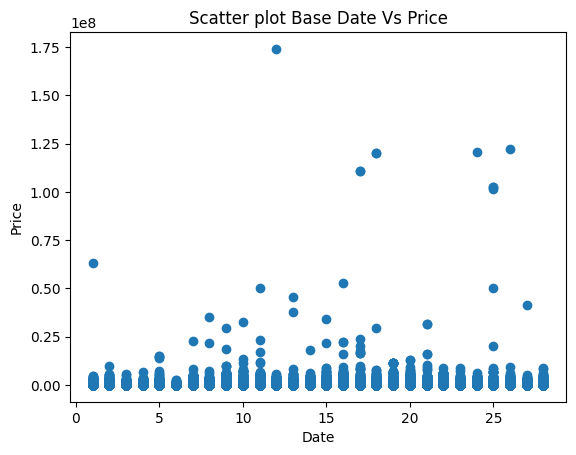

In [13]:
plt.scatter(df['Day'], df['Price'])
plt.title('Scatter plot Base Date Vs Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### Removing outliers

In [14]:
# remove outliers
df = df[np.abs(df.Price - df.Price.mean()) <= (3 * df.Price.std())]

In [15]:
# groupby
df_group = df[['ID', 'Product', 'Price', 'Area', 'Type']].groupby('ID').agg({'Area':'first', 'Type':'first', 'Product':'count','Price':'mean'})

In [16]:
df_group.reset_index(inplace = True)

In [17]:
df_group.rename(columns = {'Product':'ProductCount'}, inplace = True)

In [18]:
df_group.describe()

,ProductCount,Price
count,17026.000000,17026.000000
mean,197.689181,174631.668660
std,418.673890,82149.844119
min,1.000000,1000.000000
25%,12.000000,116324.485857
50%,52.000000,158000.000000
75%,193.000000,217649.025341
max,8939.000000,962576.923077


### Encoding Date

In [19]:
lb_enc = LabelEncoder()

In [20]:
df_enc = df_group.copy()

In [21]:
df_enc['AreaEnc'] = lb_enc.fit_transform(df_enc['Area'])

In [22]:
df_enc['TypeEnc'] = lb_enc.fit_transform(df_enc['Type'])

In [23]:
df_enc.describe()

,ProductCount,Price,AreaEnc,TypeEnc
count,17026.000000,17026.000000,17026.000000,17026.000000
mean,197.689181,174631.668660,0.784036,5.298074
std,418.673890,82149.844119,0.715300,2.246227
min,1.000000,1000.000000,0.000000,0.000000
25%,12.000000,116324.485857,0.000000,2.000000
50%,52.000000,158000.000000,1.000000,6.000000
75%,193.000000,217649.025341,1.000000,6.000000
max,8939.000000,962576.923077,2.000000,8.000000


### Normalizing Date

In [24]:
df_type = df_enc.copy()

In [25]:
scaler = MinMaxScaler()

In [26]:
df_type[['ProductCountNorm', 'PriceNorm','AreaNorm','TypeNorm']] = scaler.fit_transform(df_type[['ProductCount',	'Price',	'AreaEnc',	'TypeEnc']])

In [27]:
df_type.drop(['ID',	'Area',	'Type'], axis = 1, inplace = True)

<Axes: >

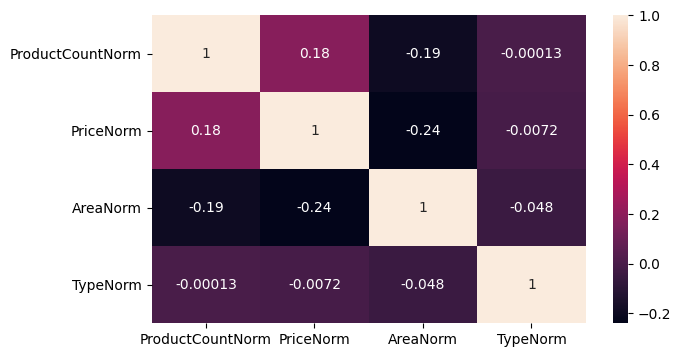

In [28]:
df_corr = df_type[['ProductCountNorm',	'PriceNorm',	'AreaNorm',	'TypeNorm']].corr()
plt.figure(figsize=(7,4))
sns.heatmap(df_corr, annot=True)

c:\Users\SnappMarket\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


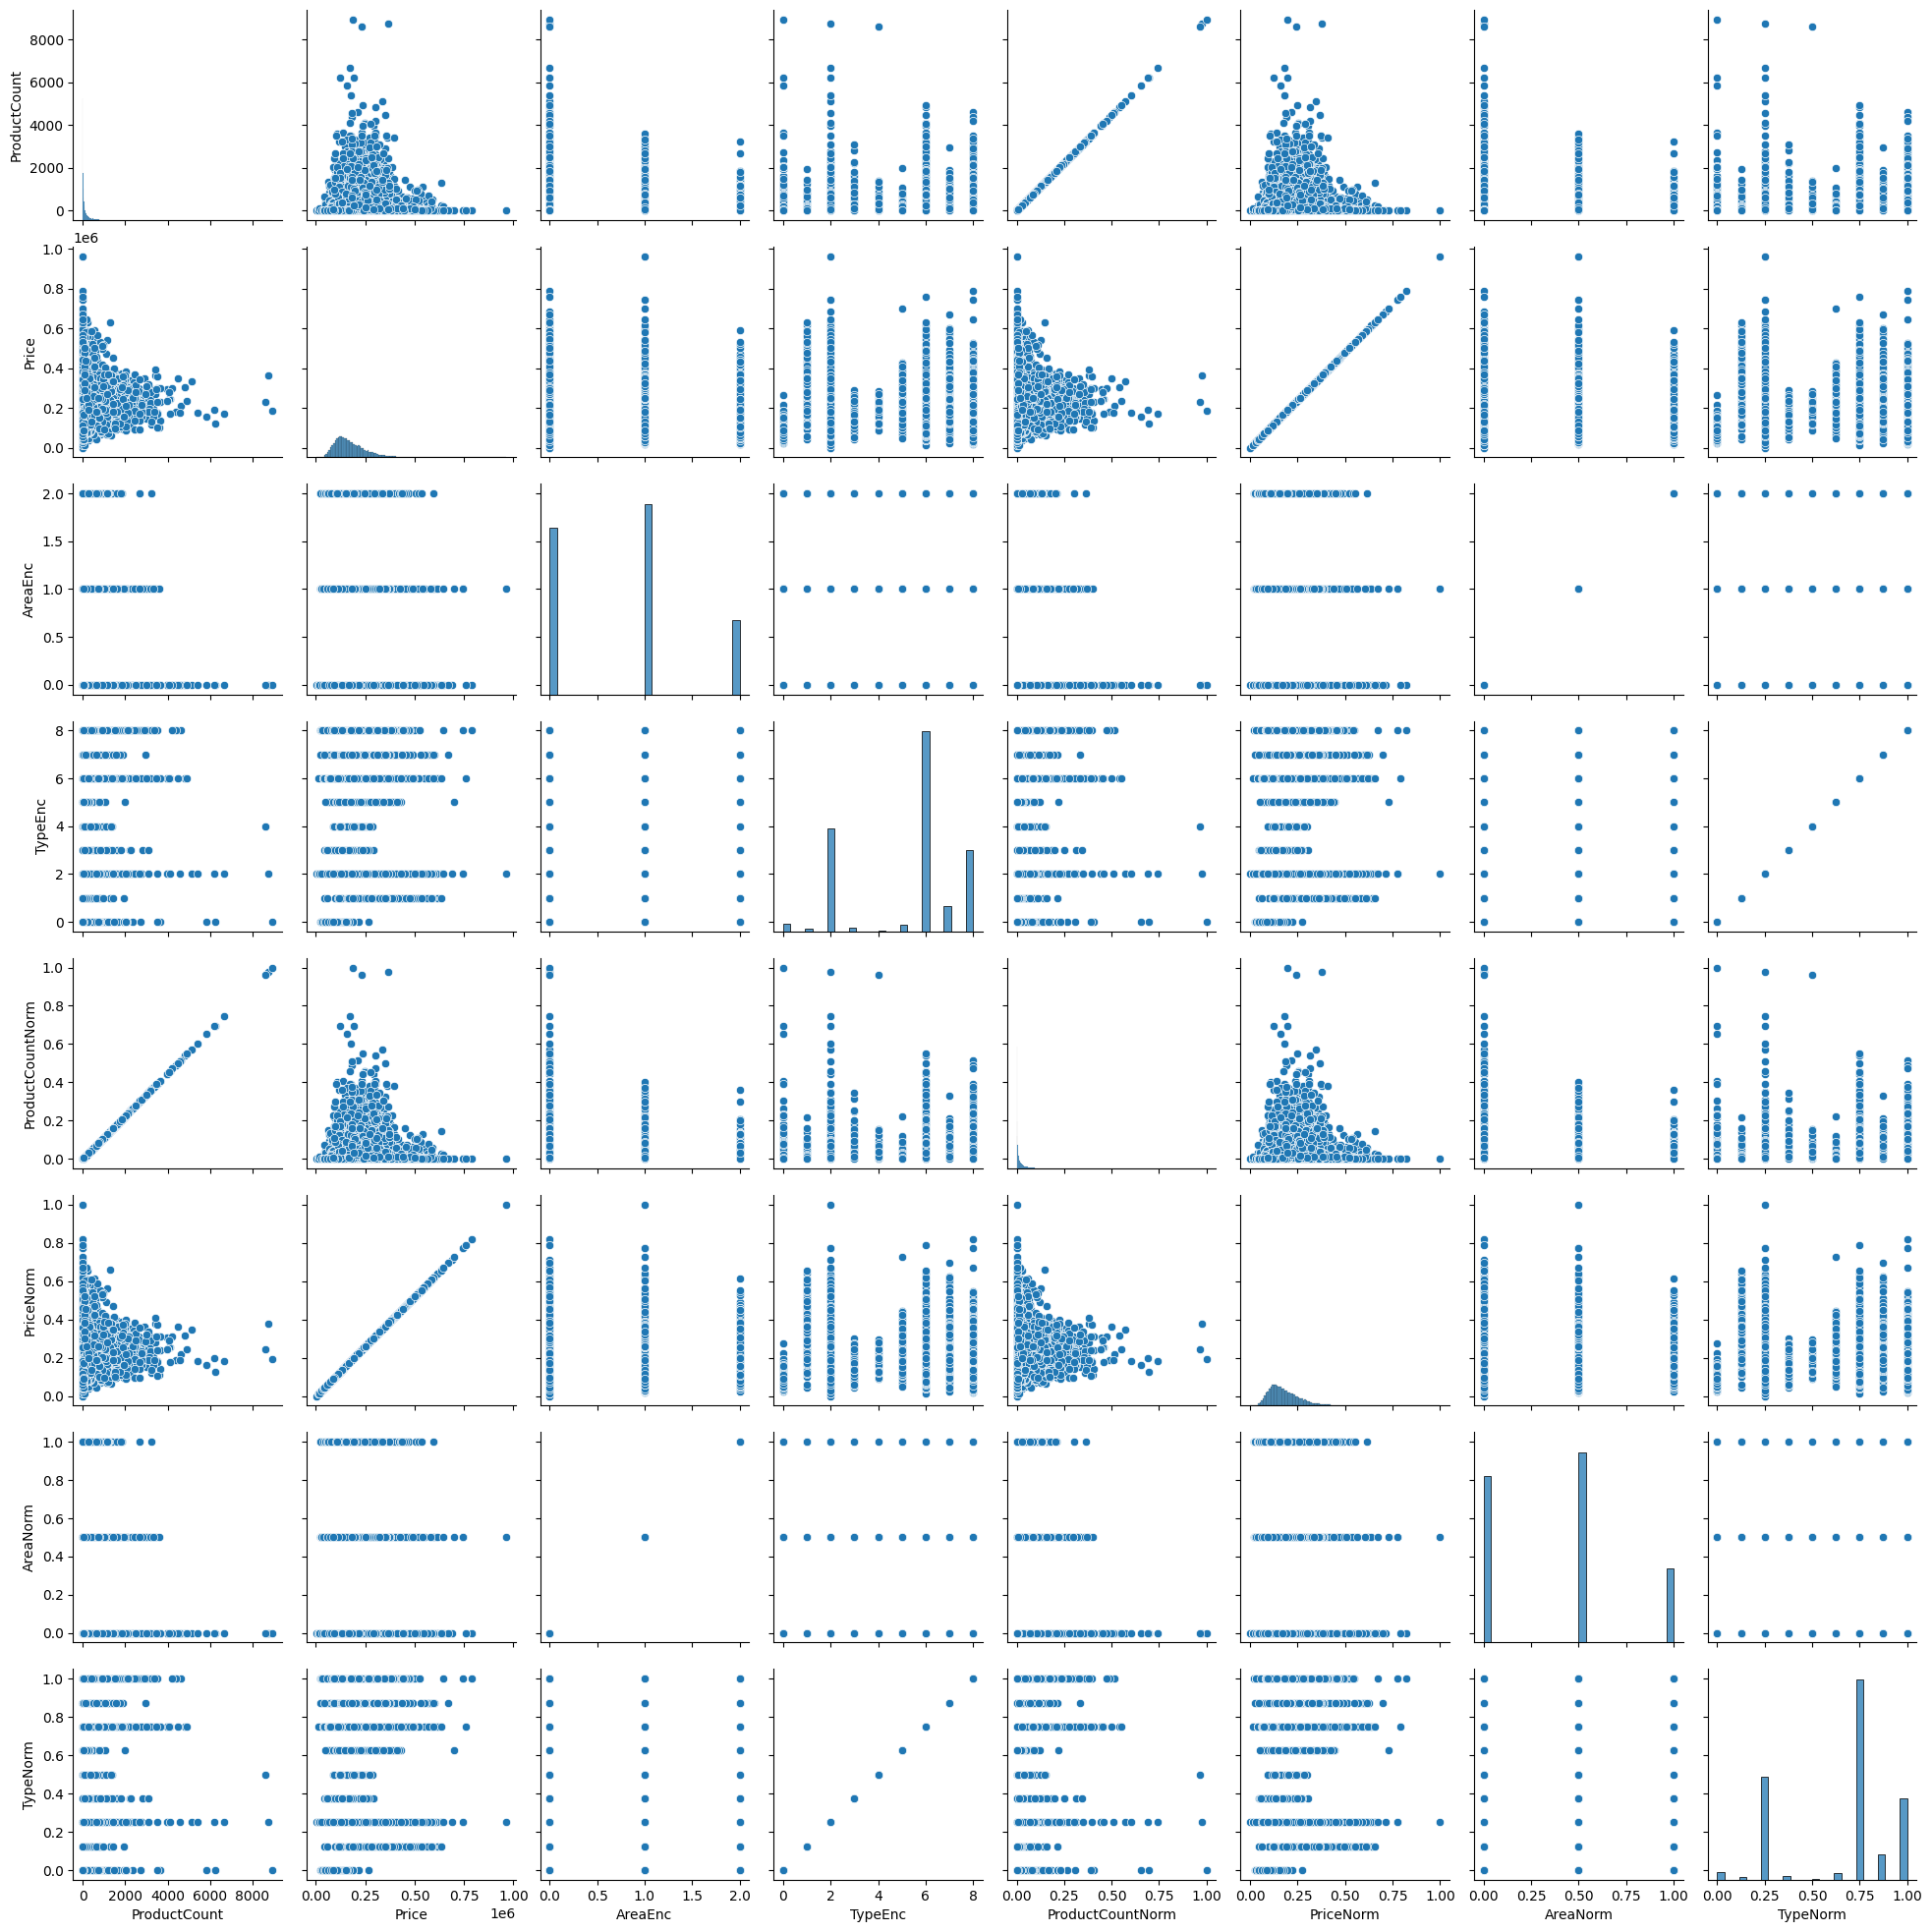

In [29]:
sns.pairplot(df_type, size=2.5)

In [30]:
l_features = ['ProductCountNorm','TypeNorm','AreaNorm']

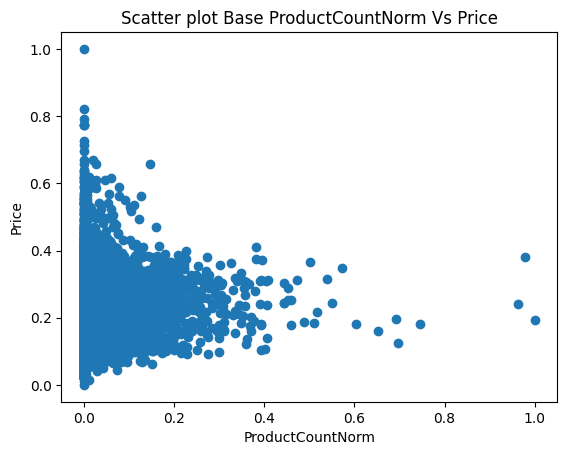

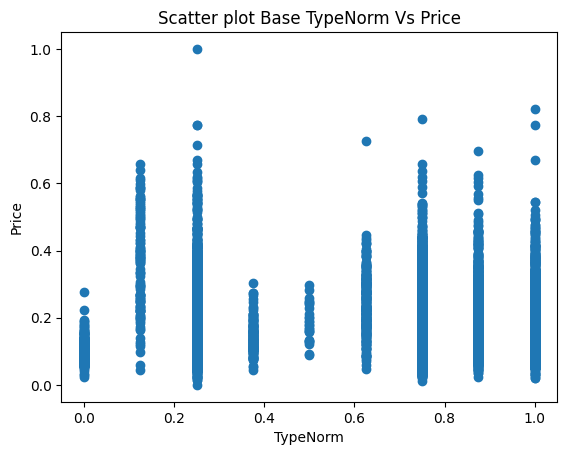

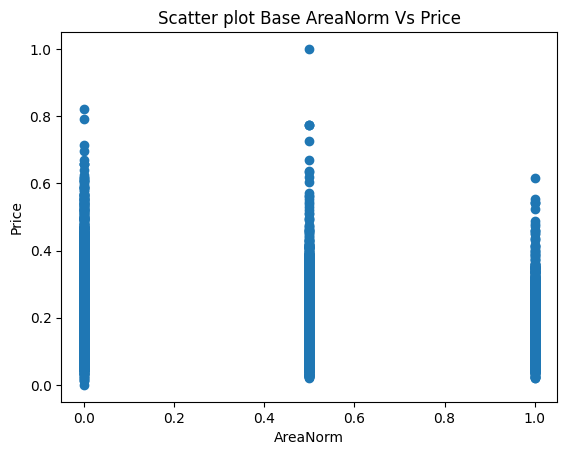

In [31]:
for i in l_features:
    plt.scatter(df_type[i], df_type['PriceNorm'])
    plt.title(f'Scatter plot Base {i} Vs Price')
    plt.xlabel(i)
    plt.ylabel('Price')
    plt.show()

In [32]:
X = df_type.drop(['PriceNorm','ProductCount', 'Price','AreaEnc','TypeEnc'], axis=1)
y = df_type['PriceNorm']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [34]:
# Create a new test dataset with the same columns as the training dataset
df_test = pd.concat([pd.DataFrame(X_test, columns=X.columns), pd.DataFrame(y_test, columns=['Target'])], axis=1)

## Preparing Models

### Linear Regression

In [35]:
###Linear Regression Model
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [36]:
CoefficientModel = lin_reg_model.coef_

In [37]:
print('Coefficient of model :', CoefficientModel)

Coefficient of model : [ 0.26610976 -0.04984329 -0.00478715]


In [38]:
InterceptModel = lin_reg_model.intercept_

In [39]:
print('Intercept of model :',InterceptModel)

Intercept of model : 0.1971791442262967


In [40]:
# Root Mean Squared Error on training dataset
predict_train_lin = lin_reg_model.predict(X_train)
rmse_train_lin = mean_squared_error(y_train,predict_train_lin)**(0.5)
print('RMSE on train dataset : ', rmse_train_lin)

RMSE on train dataset :  0.08109363123586567


In [41]:
y_pred_lin = lin_reg_model.predict(X_test)
mean_squared_error_lin = mean_squared_error(y_test, y_pred_lin)
print("Mean Squared Error:", mean_squared_error_lin)

Mean Squared Error: 0.007363090887509936


### Decision Tree Regressor

In [42]:
dec_reg_model = DecisionTreeRegressor(random_state=1)
dec_reg_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

In [43]:
y_pred_dec = dec_reg_model.predict(X_test)
mean_squared_error_dec = mean_squared_error(y_test, y_pred_dec)**(0.5)
print("Mean Squared Error is ", mean_squared_error_dec)

Mean Squared Error is  0.09273868917667723


### Random Forest Regressor

In [44]:
ran_reg_model = RandomForestRegressor(random_state=1)
ran_reg_model.fit(X_train, y_train)

RandomForestRegressor(random_state=1)

In [45]:
y_pred_ran = ran_reg_model.predict(X_test)
mean_squared_error_ran = mean_squared_error(y_test, y_pred_ran)**(0.5)
print("Root Mean Squared Error is ", mean_squared_error_ran)

Root Mean Squared Error is  0.08737839952698298


## Evaluating Models 

In [46]:
dict_errors = ({'mean_squared_error_ran':mean_squared_error_ran,'mean_squared_error_dec':mean_squared_error_dec,'mean_squared_error_lin': mean_squared_error_lin})
min_error = min(dict_errors, key=dict_errors.get)
print("Minimum error is:", dict_errors[min_error], "for", min_error)

Minimum error is: 0.007363090887509936 for mean_squared_error_lin


In [47]:
print(y_pred_lin)

[0.17316284 0.19474815 0.17290663 ... 0.17247219 0.17262692 0.1716264 ]


In [48]:
df_test['Target'] = y_pred_lin

In [49]:
y = y_pred_lin.reshape(-1, 1)
# np.tile(y, (1, 4)).shape
scaler.inverse_transform(np.tile(y, (1, 4)))[:, 1]

array([167509.38678215, 188265.3311862 , 167263.02327636, ...,
       166845.27409214, 166994.06678316, 166031.98105653])

In [51]:
df_test['TargetReal'] = (scaler.inverse_transform(np.tile(y, (1, 4)))[:, 1])	

In [52]:
df_test.describe()

,ProductCountNorm,AreaNorm,TypeNorm,Target,TargetReal
count,3406.000000,3406.000000,3406.000000,3406.000000,3406.000000
mean,0.021670,0.384028,0.661113,0.180640,174698.976615
std,0.044100,0.356682,0.282552,0.023060,22174.401617
min,0.000000,0.000000,0.000000,0.142549,138071.541937
25%,0.001231,0.000000,0.250000,0.168846,163358.197901
50%,0.005594,0.500000,0.750000,0.173868,168187.813917
75%,0.021369,0.500000,0.750000,0.196000,189469.443395
max,0.653502,1.000000,1.000000,0.371082,357824.254475


In [53]:
df_test.head()

,ProductCountNorm,AreaNorm,TypeNorm,Target,TargetReal
6294,0.016894,0.5,0.75,0.173163,167509.386782
12480,0.098009,0.5,0.75,0.194748,188265.331186
14715,0.006937,0.5,0.25,0.172907,167263.023276
1283,0.004587,1.0,0.75,0.144966,140396.130179
6472,0.002350,0.5,1.00,0.168096,162636.827434


## Evaluating each model

In [54]:
# Define the models
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]

In [55]:
# Evaluate each model
for model in models:
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Evaluate the model using 10-fold cross-validation
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error')

    # Calculate the mean squared error and print the results
    mse = -scores.mean()
    print(f'Model: {model.__class__.__name__}, Mean Squared Error: {mse:.5f}')

Model: LinearRegression, Mean Squared Error: 0.00658
Model: DecisionTreeRegressor, Mean Squared Error: 0.00798
Model: RandomForestRegressor, Mean Squared Error: 0.00700


In [56]:
# define the models
lin_reg_model = LinearRegression()
dec_reg_model = DecisionTreeRegressor()
rf_reg_model = RandomForestRegressor()

In [57]:
# train the models
lin_reg_model.fit(X_train, y_train)
dec_reg_model.fit(X_train, y_train)
rf_reg_model.fit(X_train, y_train)

RandomForestRegressor()

In [58]:
# make predictions on the test set
lin_reg_pred = lin_reg_model.predict(X_test)
dec_reg_pred = dec_reg_model.predict(X_test)
rf_reg_pred = rf_reg_model.predict(X_test)

In [59]:
# evaluate the models
mse_lin_reg = mean_squared_error(y_test, lin_reg_pred)
mse_dec_reg = mean_squared_error(y_test, dec_reg_pred)
mse_rf_reg = mean_squared_error(y_test, rf_reg_pred)

In [60]:
# print the results
print(f"Model: {lin_reg_model.__class__.__name__}, Mean Squared Error: {mse_lin_reg:.5f}")
print(f"Model: {dec_reg_model.__class__.__name__}, Mean Squared Error: {mse_dec_reg:.5f}")
print(f"Model: {rf_reg_model.__class__.__name__}, Mean Squared Error: {mse_rf_reg:.5f}")

Model: LinearRegression, Mean Squared Error: 0.00736
Model: DecisionTreeRegressor, Mean Squared Error: 0.00861
Model: RandomForestRegressor, Mean Squared Error: 0.00764
